# Forecasting Walmart sales using Time Series prediction methods

### Methods and models used in the solution:
* SARIMAX
* Exponential Smoothing
* ARIMA

### Why did I decide to use Time Series prediction models?
* There is a 'Date' column in train dataset and we can make this column an ​​index of our data and use time series analysis models that can even take into account the seasonality that we have.

In [249]:
import pandas as pd 

train = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/train.csv')
stores = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/stores.csv')
features = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/features.csv')
test = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/test.csv')

#### Import libraries

In [250]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pylab import rcParams

In [251]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [252]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [253]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [254]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


#### Combine all datasets into one table

In [255]:
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

In [256]:
data_test = test.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [258]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday_x   115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  IsHoliday_y   115064 non-null  bool   
 14  Type          115064 non-null  object 
 15  Size          115064 non-null  int64  
dtypes: bool(2), float64(9), int64(3), object(2)
memory usage: 12.5+ MB


#### Checking for passes

In [259]:
data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

In [260]:
data_test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday_x         0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
IsHoliday_y         0
Type                0
Size                0
dtype: int64

#### Processing passes

In [261]:
data['MarkDown1'].fillna(value=0,inplace=True)
data['MarkDown2'].fillna(value=0,inplace=True)
data['MarkDown3'].fillna(value=0,inplace=True)
data['MarkDown4'].fillna(value=0,inplace=True)
data['MarkDown5'].fillna(value=0,inplace=True)

In [262]:
data_test['MarkDown1'].fillna(value=0,inplace=True)
data_test['MarkDown2'].fillna(value=0,inplace=True)
data_test['MarkDown3'].fillna(value=0,inplace=True)
data_test['MarkDown4'].fillna(value=0,inplace=True)

#### Removing an extra column

In [263]:
data.drop(['IsHoliday_y'], axis=1,inplace=True)

In [264]:
data.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [265]:
data.shape

(421570, 16)

In [266]:
data_test.drop(['IsHoliday_y'], axis=1,inplace=True)

In [267]:
data_test.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [268]:
data_test.shape

(115064, 15)

## Exploratory Data Analysis

Text(0.5, 1.0, 'Weekly Sales')

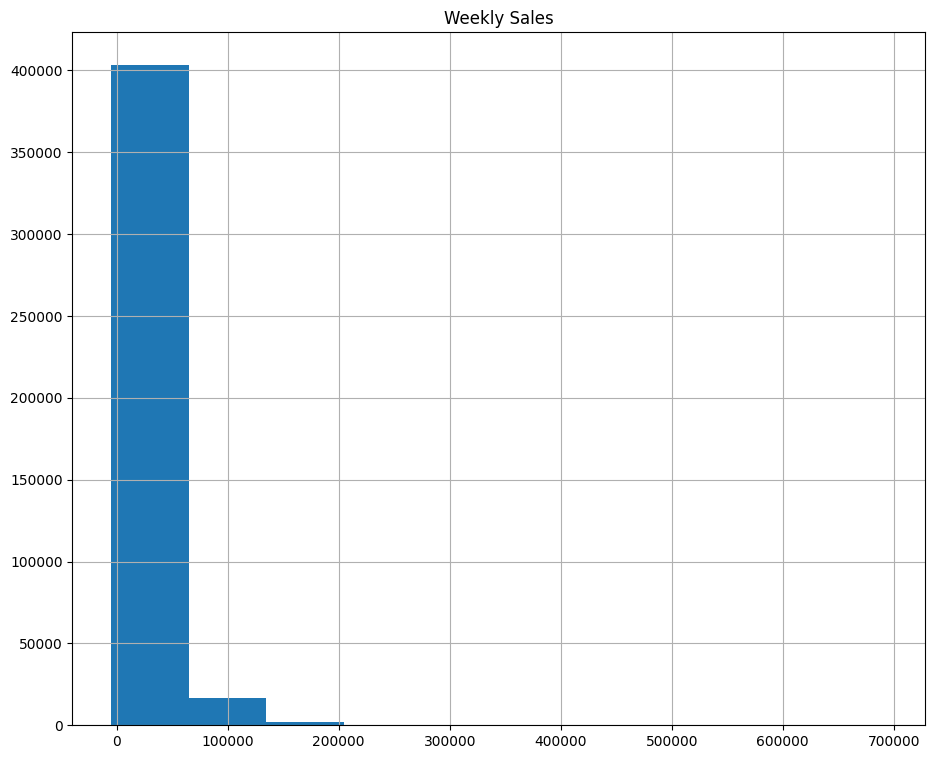

In [269]:
data['Weekly_Sales'].hist()
plt.title('Weekly Sales') 

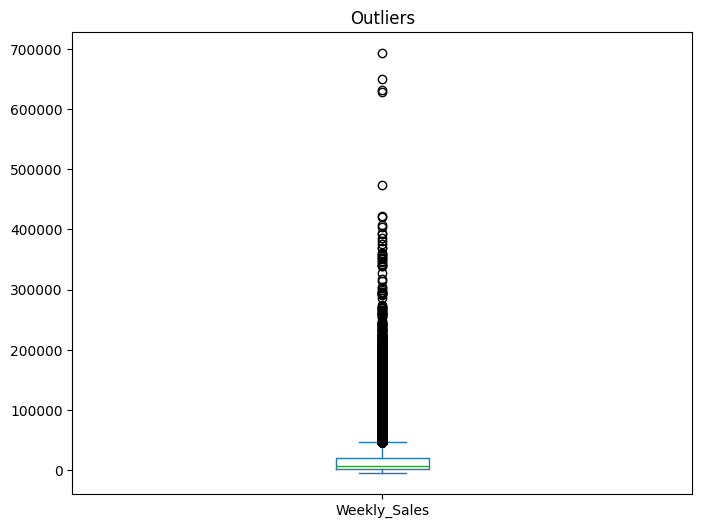

In [270]:
plt.figure(figsize=(8,6))
data['Weekly_Sales'].plot(kind='box')
plt.title('Outliers')
plt.show()

#### Remove outliers in the target variable

In [271]:
data = data[data['Weekly_Sales'] < 100000] 

Text(0.5, 1.0, 'Weekly Sales')

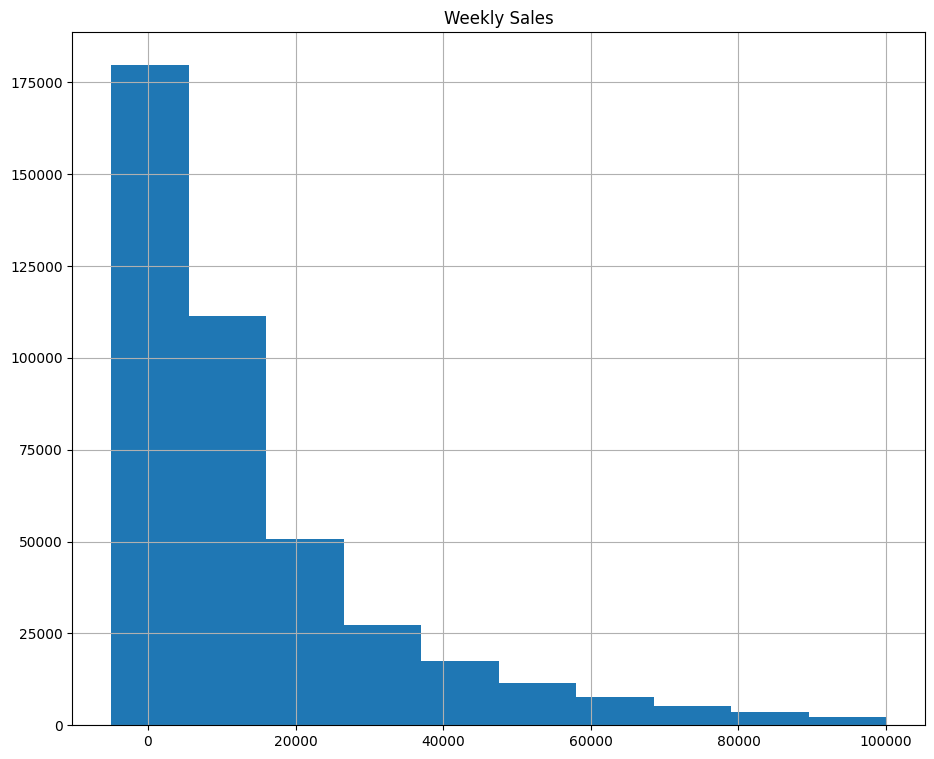

In [272]:
data['Weekly_Sales'].hist()
plt.title('Weekly Sales')

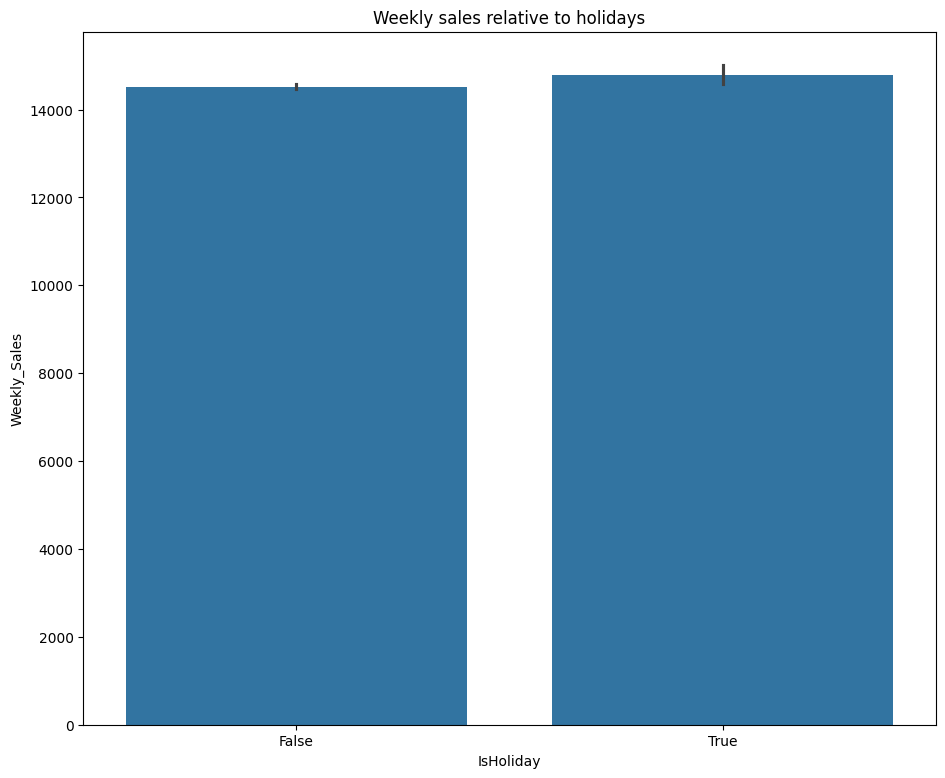

In [273]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.title('Weekly sales relative to holidays')
plt.show()

#### Pull out the dates of important holidays from the Date column and write them in our table

In [274]:
data_holiday = data.loc[data['IsHoliday']==True]
data_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [275]:
data_not_holiday = data.loc[data['IsHoliday']==False]
data_not_holiday['Date'].nunique() 

133

In [276]:
data.loc[(data['Date'] == '2010-02-12')|(data['Date'] == '2011-02-11')|(data['Date'] == '2012-02-10'),'Super_Bowl'] = True
data.loc[(data['Date'] != '2010-02-12')&(data['Date'] != '2011-02-11')&(data['Date'] != '2012-02-10'),'Super_Bowl'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\2622281322.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-02-12')|(data['Date'] == '2011-02-11')|(data['Date'] == '2012-02-10'),'Super_Bowl'] = True


In [277]:
data.loc[(data['Date'] == '2010-09-10')|(data['Date'] == '2011-09-09')|(data['Date'] == '2012-09-07'),'Labor_Day'] = True
data.loc[(data['Date'] != '2010-09-10')&(data['Date'] != '2011-09-09')&(data['Date'] != '2012-09-07'),'Labor_Day'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\2328727954.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-09-10')|(data['Date'] == '2011-09-09')|(data['Date'] == '2012-09-07'),'Labor_Day'] = True


In [278]:
data.loc[(data['Date'] == '2010-11-26')|(data['Date'] == '2011-11-25'),'Thanksgiving'] = True
data.loc[(data['Date'] != '2010-11-26')&(data['Date'] != '2011-11-25'),'Thanksgiving'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\1920065823.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-11-26')|(data['Date'] == '2011-11-25'),'Thanksgiving'] = True


In [279]:
data.loc[(data['Date'] == '2010-12-31')|(data['Date'] == '2011-12-30'),'Christmas'] = True
data.loc[(data['Date'] != '2010-12-31')&(data['Date'] != '2011-12-30'),'Christmas'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\15003962.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-12-31')|(data['Date'] == '2011-12-30'),'Christmas'] = True


In [280]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False


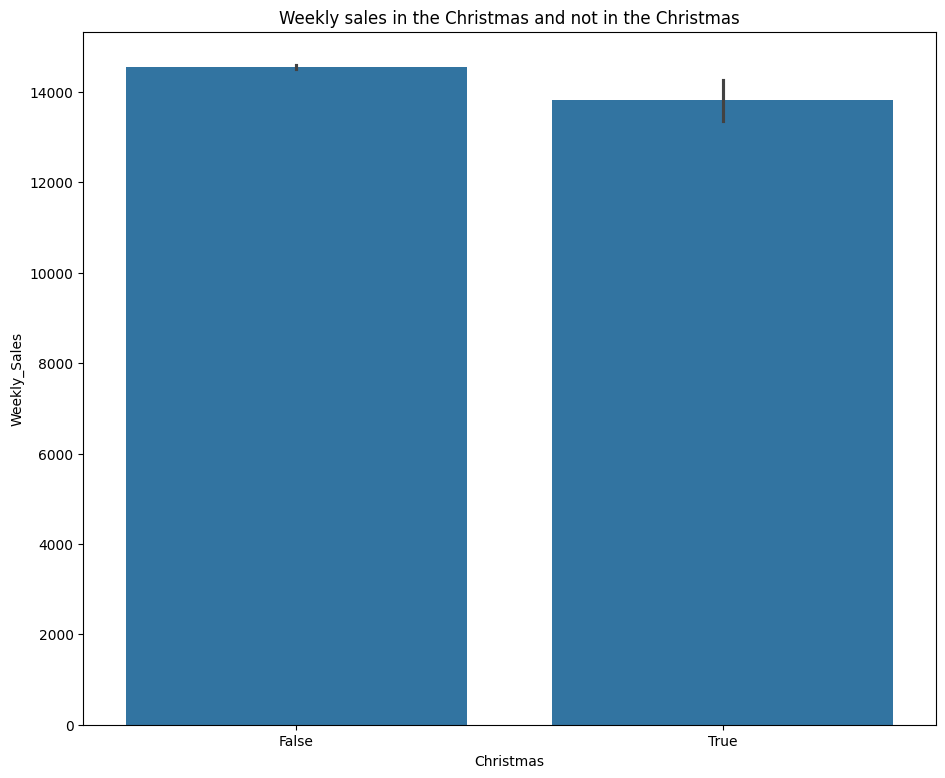

In [281]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Christmas and not in the Christmas')
plt.show()

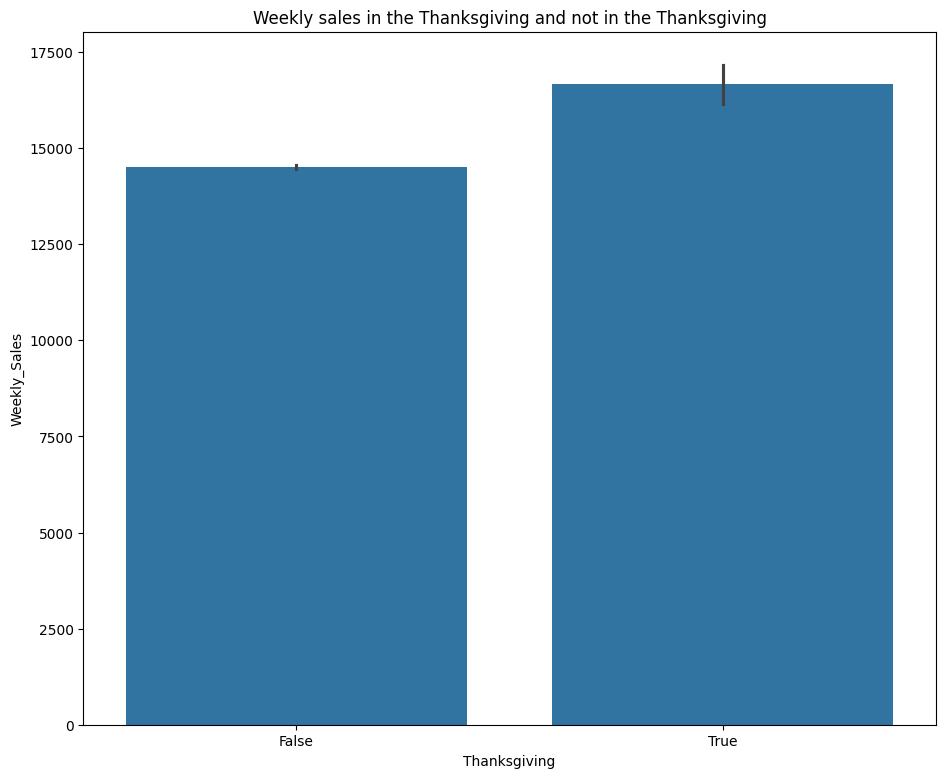

In [282]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Thanksgiving and not in the Thanksgiving')
plt.show()

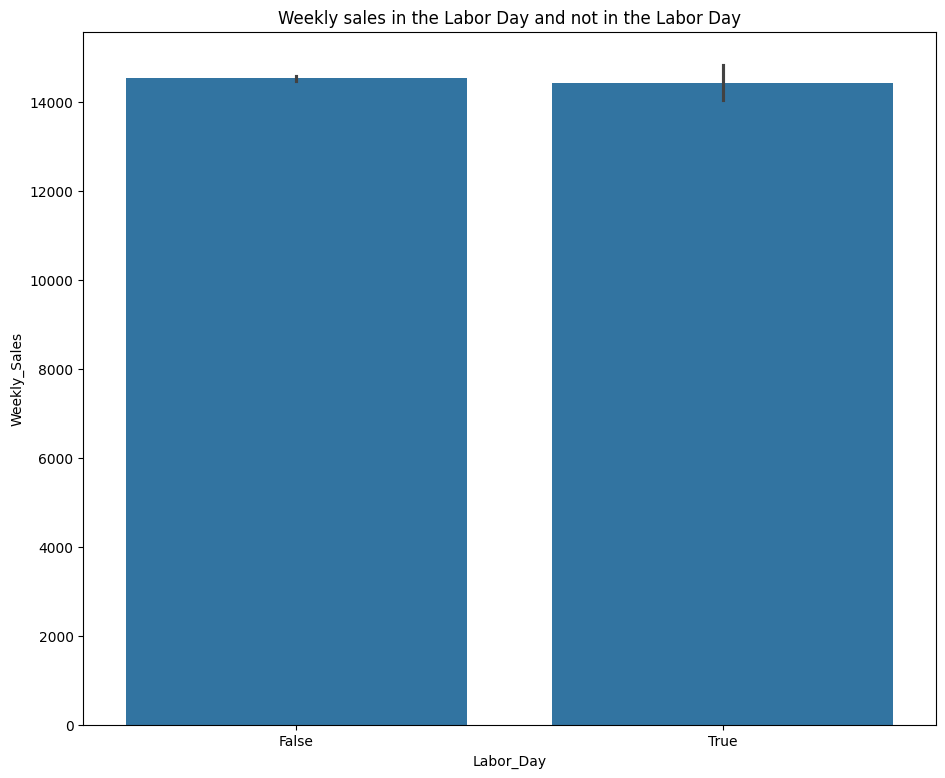

In [283]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Labor Day and not in the Labor Day')
plt.show()

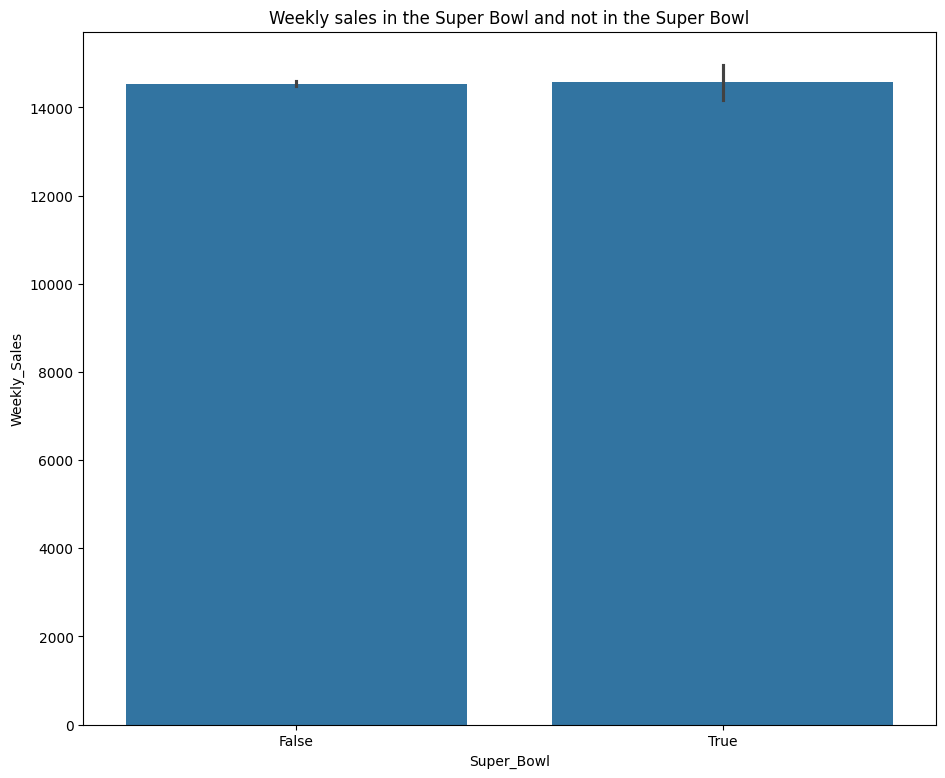

In [284]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Super Bowl and not in the Super Bowl')
plt.show()

In [285]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

### Average Monthly Sales

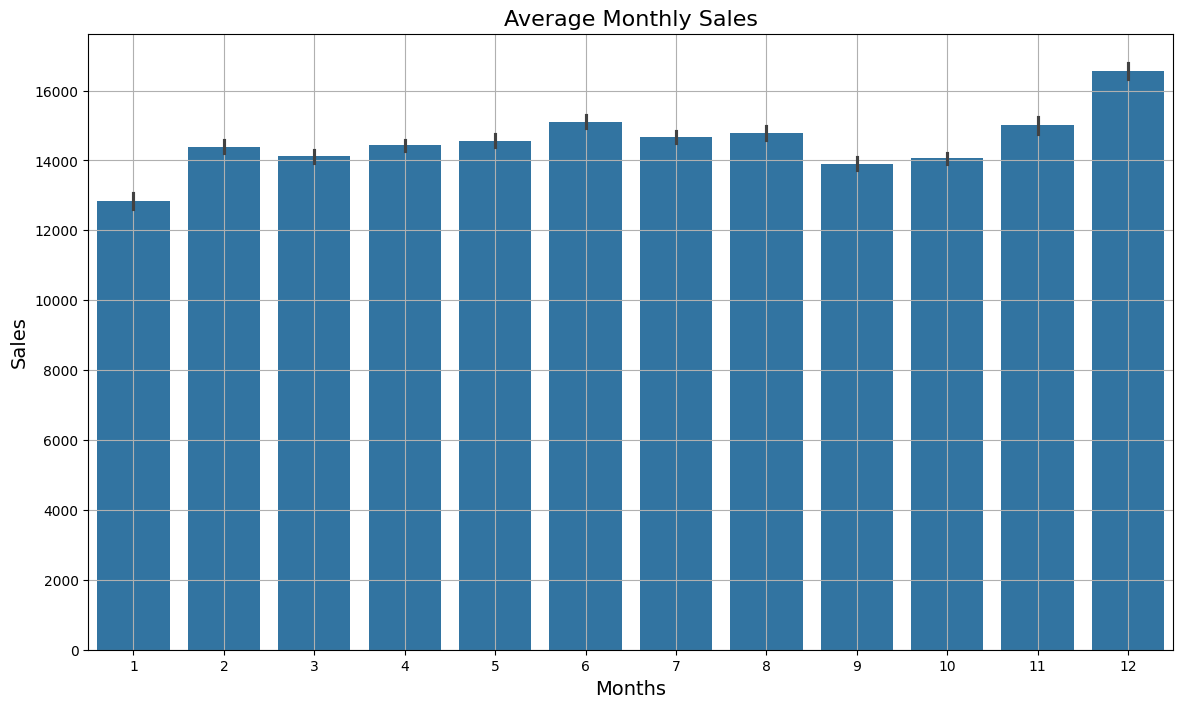

In [286]:
plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.savefig('avg_monthly_sales.png')
plt.grid()

### Average Year Sales

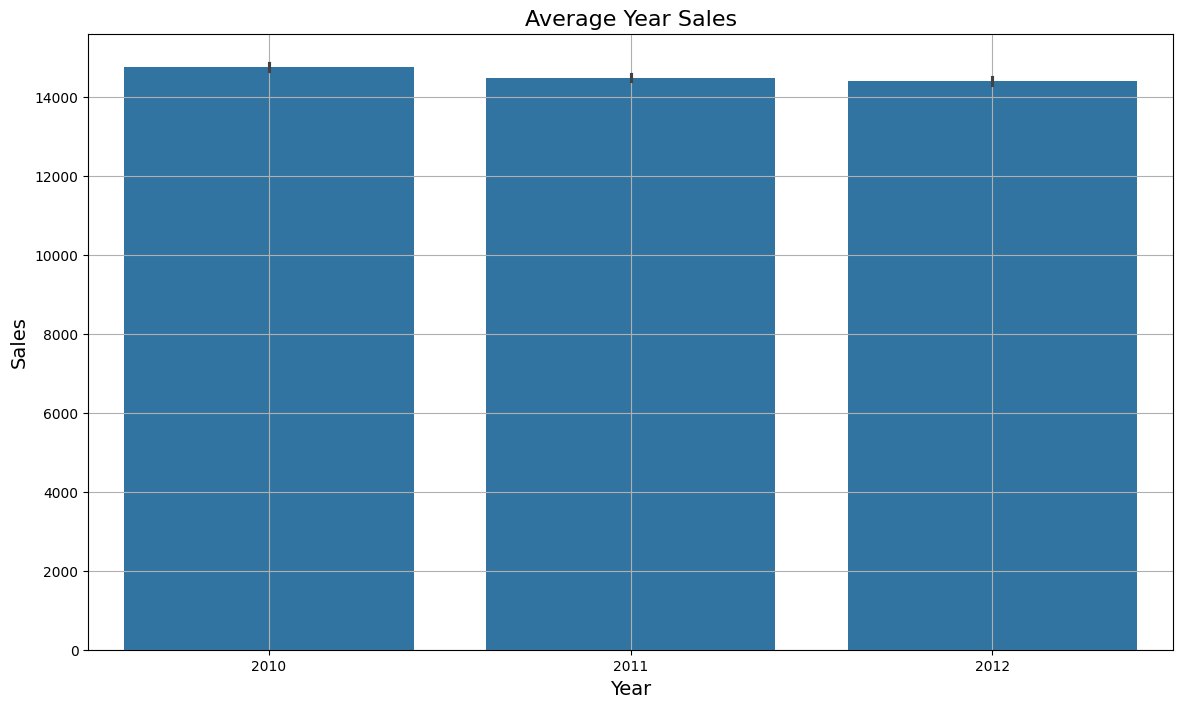

In [287]:
plt.figure(figsize=(14,8))
sns.barplot(x='Year',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.title('Average Year Sales',fontsize=16)
plt.savefig('avg_monthly_sales.png')
plt.grid()

### Effect of Temperature

C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\834497728.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Temperature'])


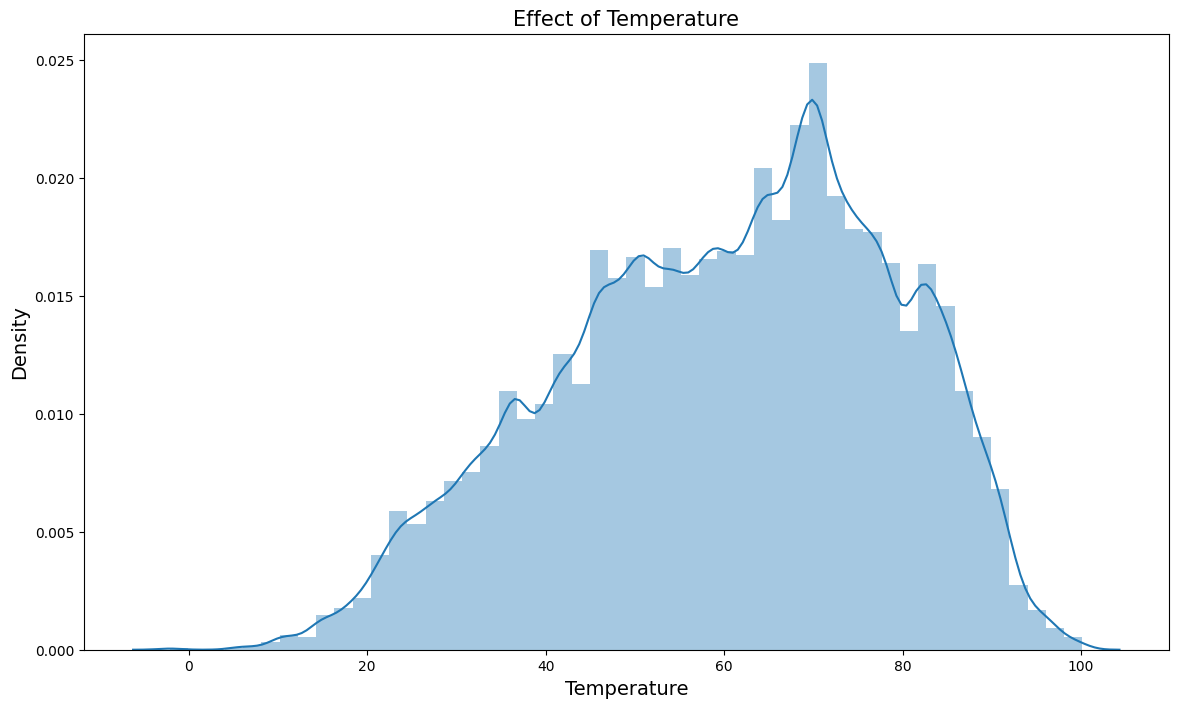

In [288]:
plt.figure(figsize=(14,8))
sns.distplot(data['Temperature'])
plt.title('Effect of Temperature',fontsize=15)
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.savefig('effect_of_temp.png')
plt.show()

### Look at the correlation of features

In [289]:
data_num = data.select_dtypes(include=['int', 'float64']).copy()

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size', 'Year', 'Month'],
      dtype='object')

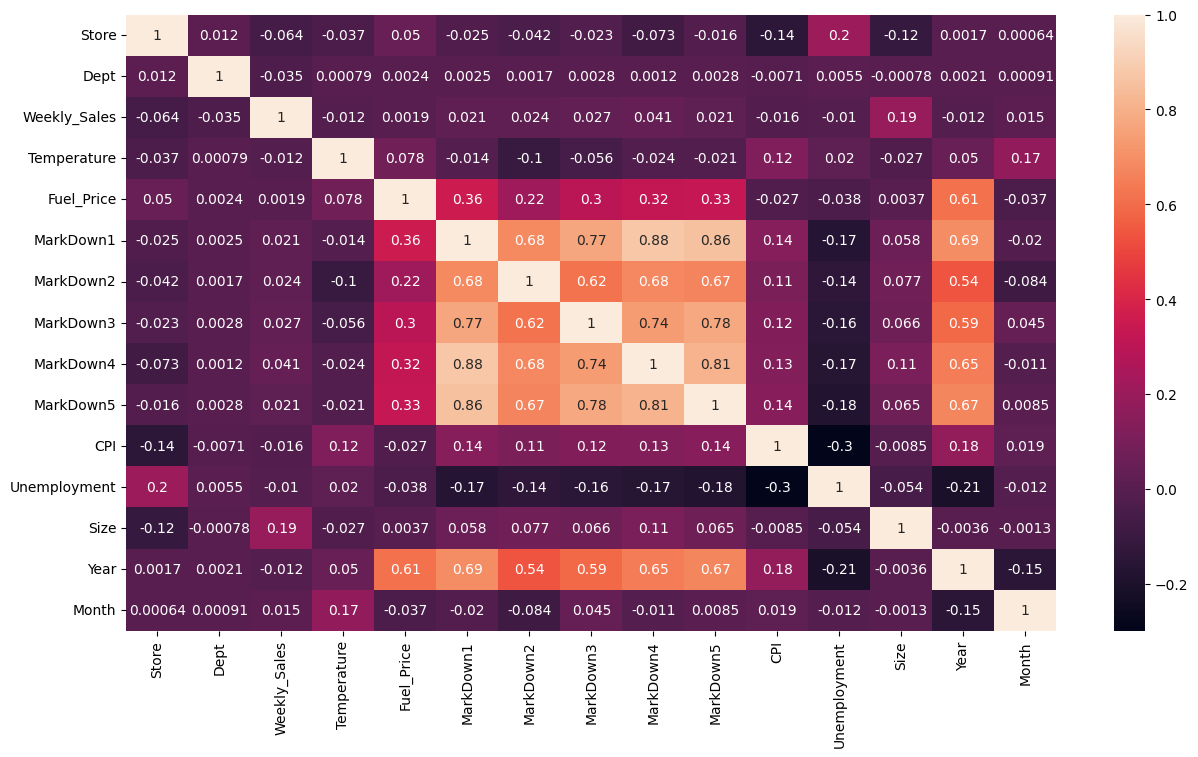

In [290]:
corr = data_num.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
data_num.columns

## Time series analysis

<Axes: xlabel='Month'>

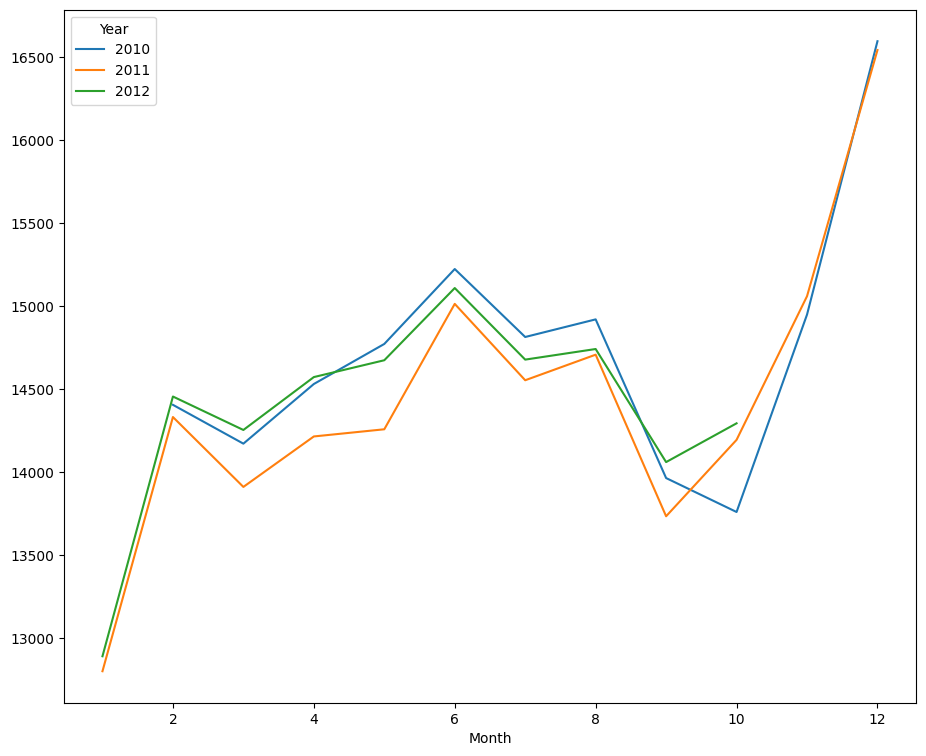

In [291]:
monthly_sales = pd.pivot_table(data, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales.plot()

[Text(0.5, 1.0, 'Average sales'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'Sales')]

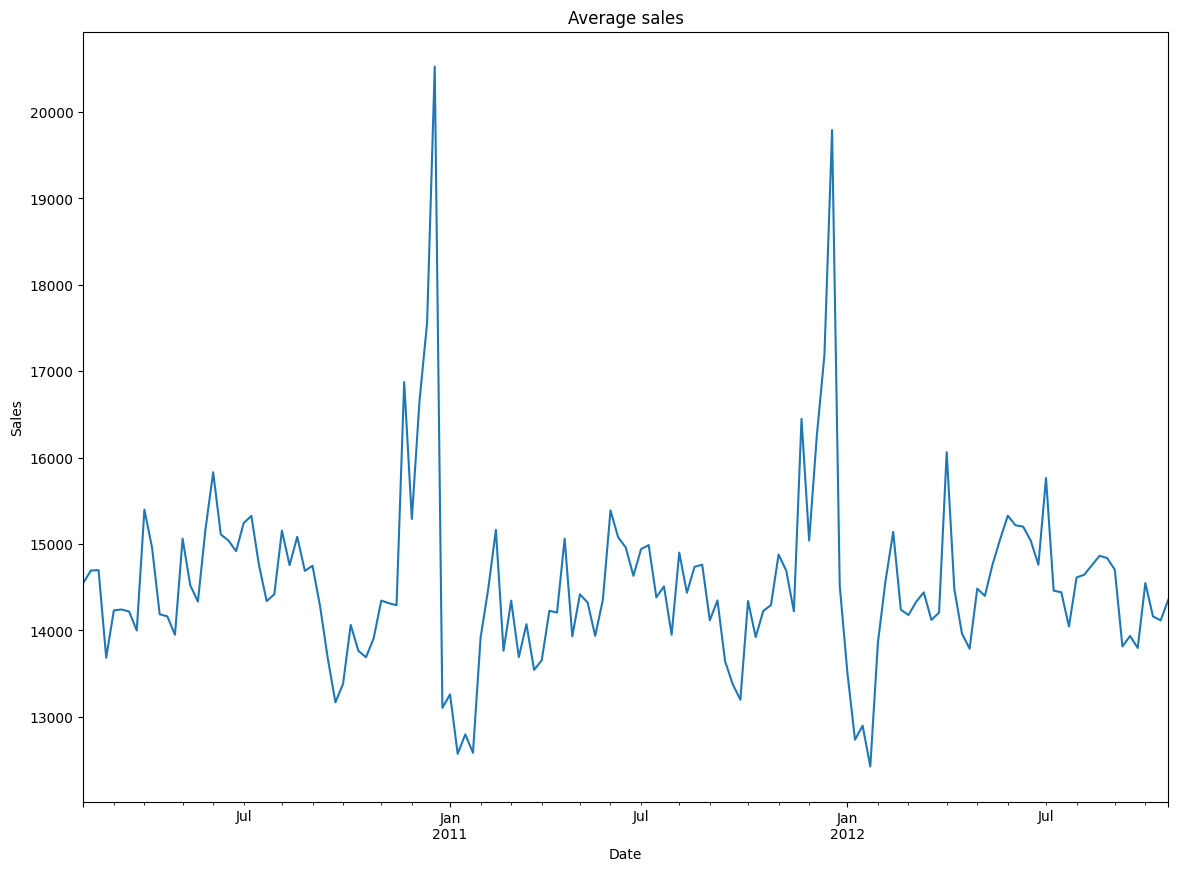

In [292]:
x = pd.pivot_table(data, values = "Weekly_Sales", index = 'Date')
ax = x.plot(figsize = (14, 10), legend =None)
ax.set(title = 'Average sales', xlabel = 'Date', ylabel = 'Sales')

In [293]:
print(data['Weekly_Sales'].rolling(window=12).mean())

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
421565    13877.672500
421566    13493.375000
421567    16943.280833
421568    17455.497500
421569    16320.806667
Name: Weekly_Sales, Length: 416430, dtype: float64


In [294]:
data_date = data[['Date', 'Weekly_Sales']]

#### We transform the dataset for prediction using manual time series analysis

In [295]:
date_date_list = list(data_date['Date'])
data_value_list = list(data_date['Weekly_Sales'])
list_dates_unique = list(data_date['Date'].unique())

In [296]:
l = {}
l1 = {}
for i in range(len(date_date_list)):
    if date_date_list[i] not in l:
        l[date_date_list[i]] = data_value_list[i]
        l1[date_date_list[i]] = 1
    else:
        l[date_date_list[i]] += data_value_list[i]
        l1[date_date_list[i]] += 1


list_values = []
for i in range(len(l)):
    list_values.append(l[list_dates_unique[i]] / l1[list_dates_unique[i]])


data_date = {'Date': list_dates_unique,
        'Sales': list_values}

data_date = pd.DataFrame(data_date)

data_date.set_index('Date', inplace=True)

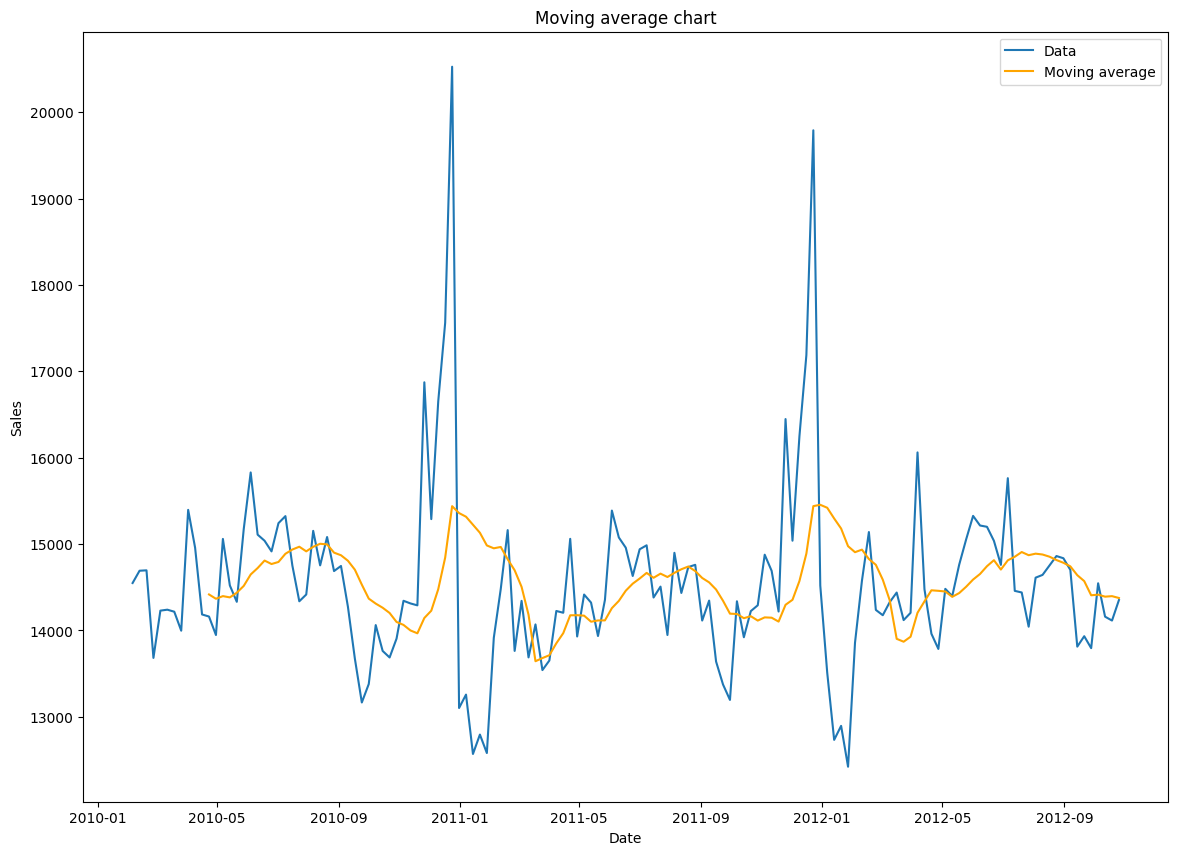

In [297]:
rolling_mean = data_date['Sales'].rolling(window=12).mean()
plt.figure(figsize = (14, 10))

plt.plot(data_date.index, data_date['Sales'], label='Data')


plt.plot(rolling_mean.index, rolling_mean, color='orange', label='Moving average')


plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Moving average chart')
plt.legend()


plt.show()

#### Dickey-Fuller test

In [298]:
result = adfuller(data_date['Sales'])
result 

(-6.668632413514585,
 4.648340133983043e-09,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2112.3540213459532)

#### Decomposition into components: trend, seasonality, noise

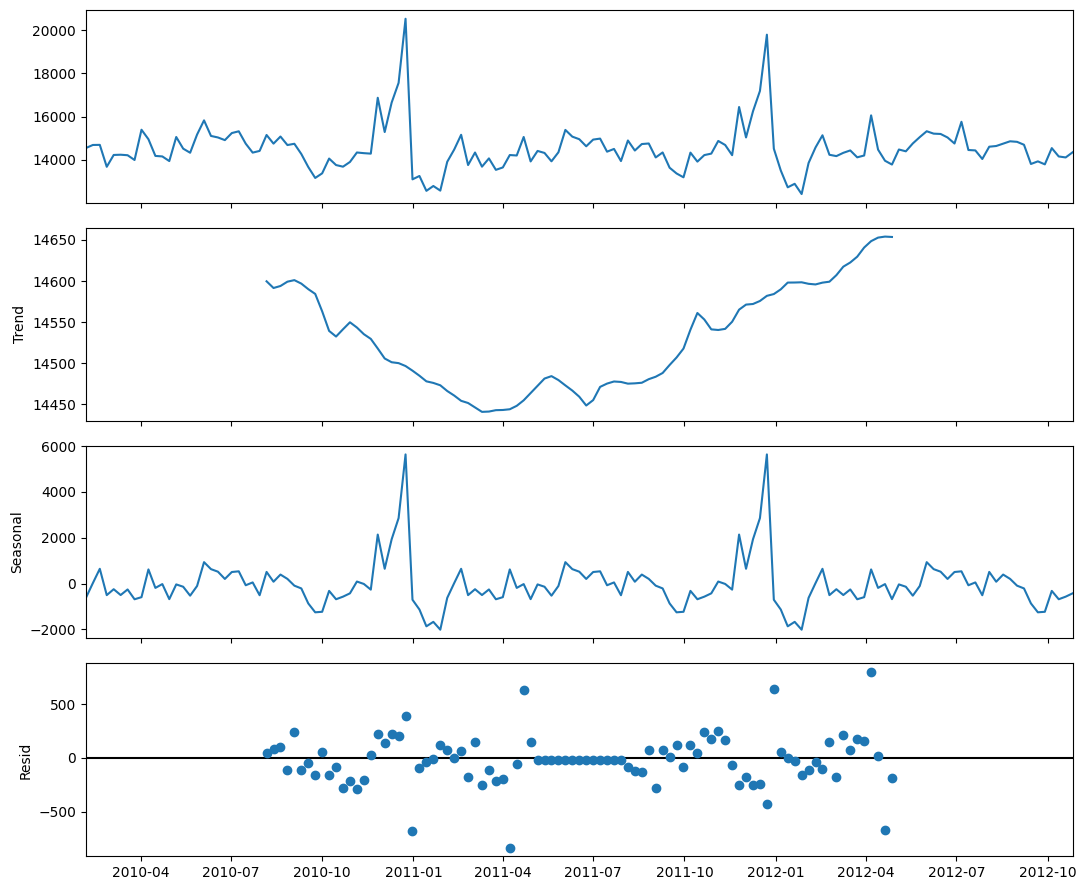

In [299]:
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(data_date)
decompose.plot()

plt.show()

#### Look at the autocorrelation

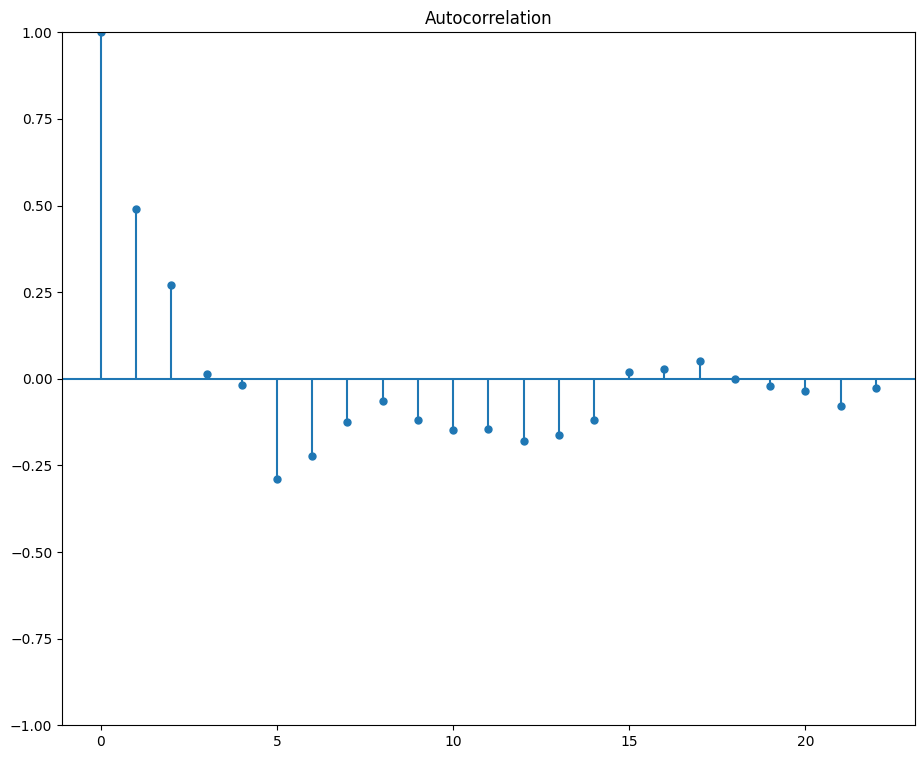

In [300]:
plot_acf(data_date, alpha = None) 
plt.show()

## Modeling with ARIMA, SARIMAX, Exponential Smoothing for time series prediction of average sales

In [301]:
train_data = data_date[:int(0.7*(len(data_date)))]
test_data = data_date[int(0.7*(len(data_date))):] 

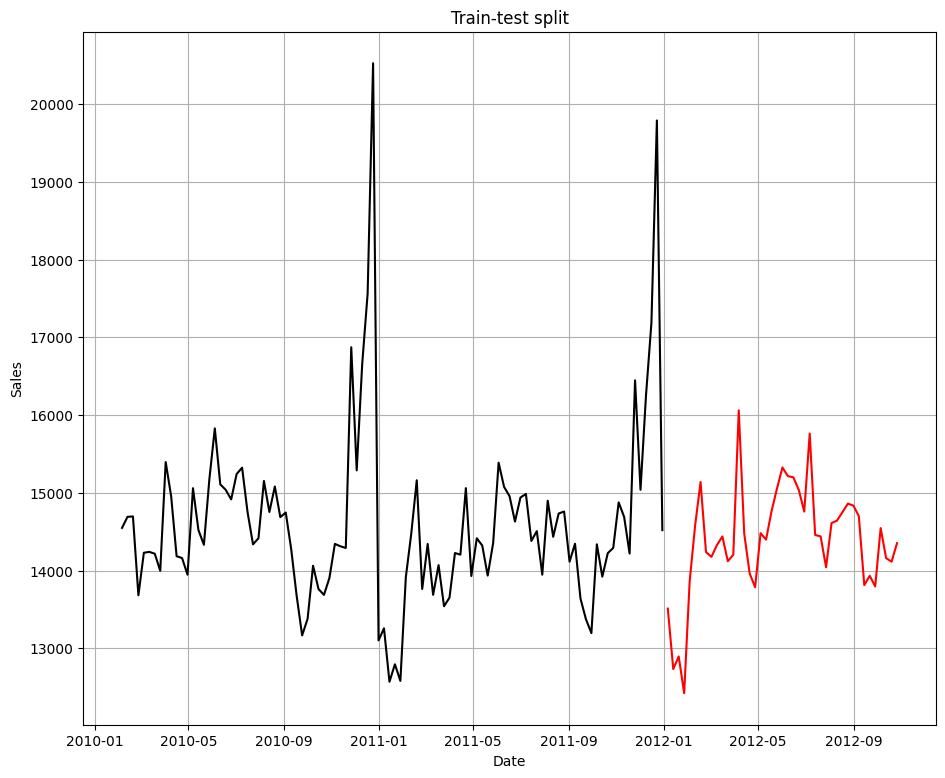

In [302]:
plt.plot(train_data, color = 'black')
plt.plot(test_data, color = 'red') 


plt.title('Train-test split')
plt.xlabel('Date')
plt.ylabel('Sales')



plt.grid()
plt.show()

#### Converting data using functionality

In [303]:
data_encoded = data.copy()
type_group = {'A':1, 'B': 2, 'C': 3}  
data_encoded['Type'] = data_encoded['Type'].replace(type_group)
data_encoded['Super_Bowl'] = data_encoded['Super_Bowl'].astype(bool).astype(int)
data_encoded['Thanksgiving'] = data_encoded['Thanksgiving'].astype(bool).astype(int)
data_encoded['Labor_Day'] = data_encoded['Labor_Day'].astype(bool).astype(int)
data_encoded['Christmas'] = data_encoded['Christmas'].astype(bool).astype(int)
data_encoded['IsHoliday'] = data_encoded['IsHoliday'].astype(bool).astype(int)
data = data_encoded

In [304]:
data.set_index('Date', inplace=True)

In [305]:
data = pd.DataFrame(data)
data_week = data.resample('W').mean()

In [306]:
test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date', inplace=True)
test = pd.DataFrame(test)


test_week = test.resample('W').mean()

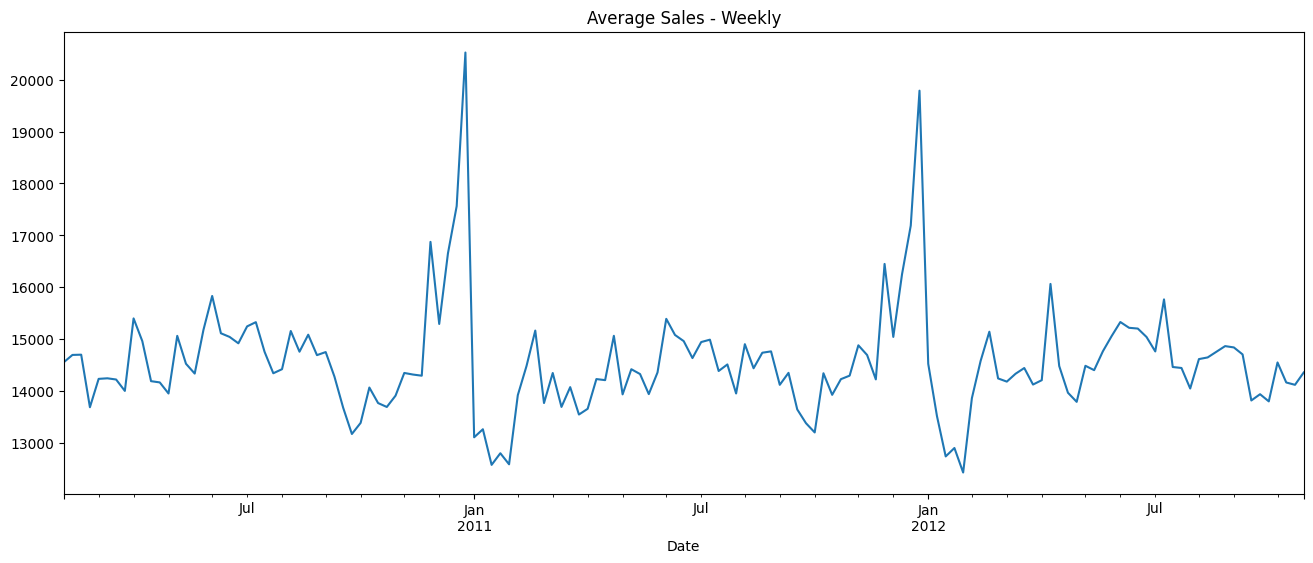

In [307]:
plt.figure(figsize=(16,6))
data_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [308]:
train_data_week = data_week[:int(0.7*(len(data_week)))] 
test_data_week = data_week[int(0.7*(len(data_week))):] 

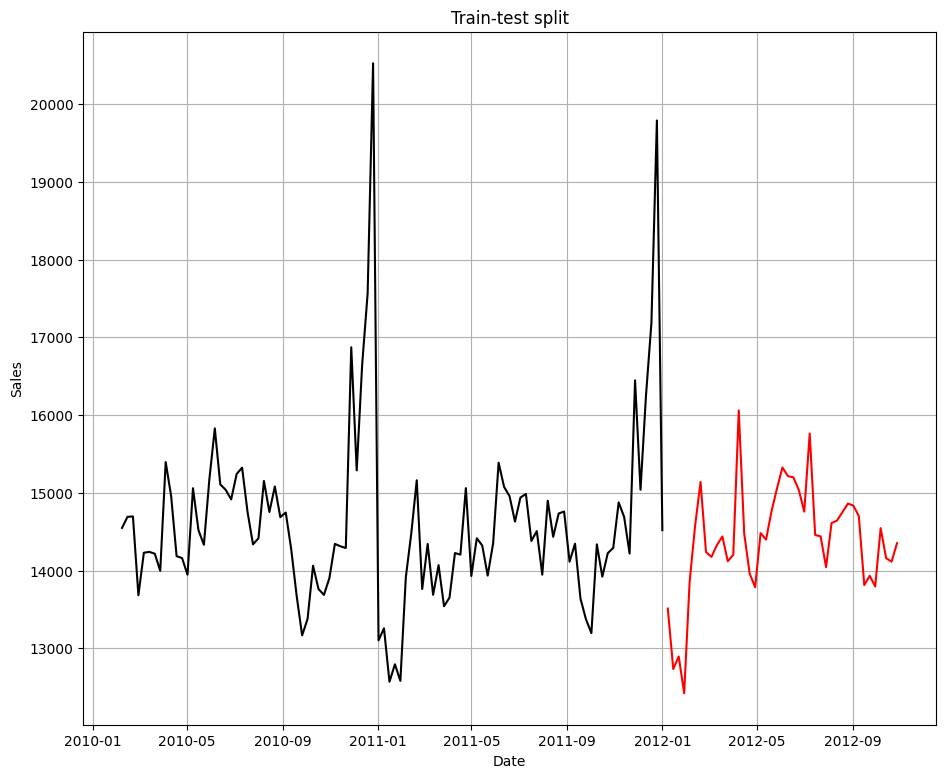

In [309]:
plt.plot(train_data_week['Weekly_Sales'], color = 'black')
plt.plot(test_data_week['Weekly_Sales'], color = 'red') 


plt.title('Train-test split')
plt.xlabel('Date')
plt.ylabel('Sales')



plt.grid()
plt.show()

#### We use the SARIMAX model with selected hyperparameters

C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


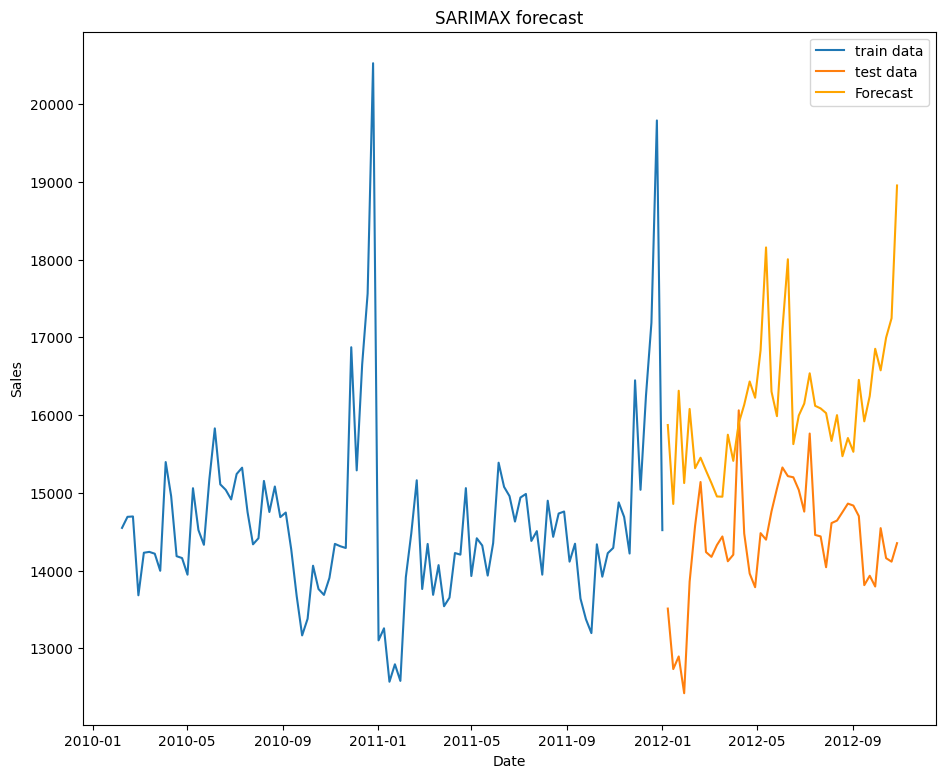

In [310]:
model = SARIMAX(train_data_week['Weekly_Sales'], order=(3, 1, 3), seasonal_order=(5, 1, 2, 24))
result = model.fit()


prediction = pd.DataFrame(result.predict(start=test_data_week.index[0], end=test_data_week.index[-1]))

plt.plot(train_data_week.index, train_data_week['Weekly_Sales'], label='train data')
plt.plot(test_data_week.index, test_data_week['Weekly_Sales'], label='test data')
plt.plot(prediction.index, prediction, color='orange', label='Forecast')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMAX forecast')
plt.legend()

plt.show()

In [311]:
print('MAE', metrics.mean_absolute_error(test_data, prediction))

MAE 1745.4954652086265


#### Let's make a prediction based on test data

In [312]:
prediction_test = pd.DataFrame(result.predict(start=test_week.index[0], end=test_week.index[-1]))

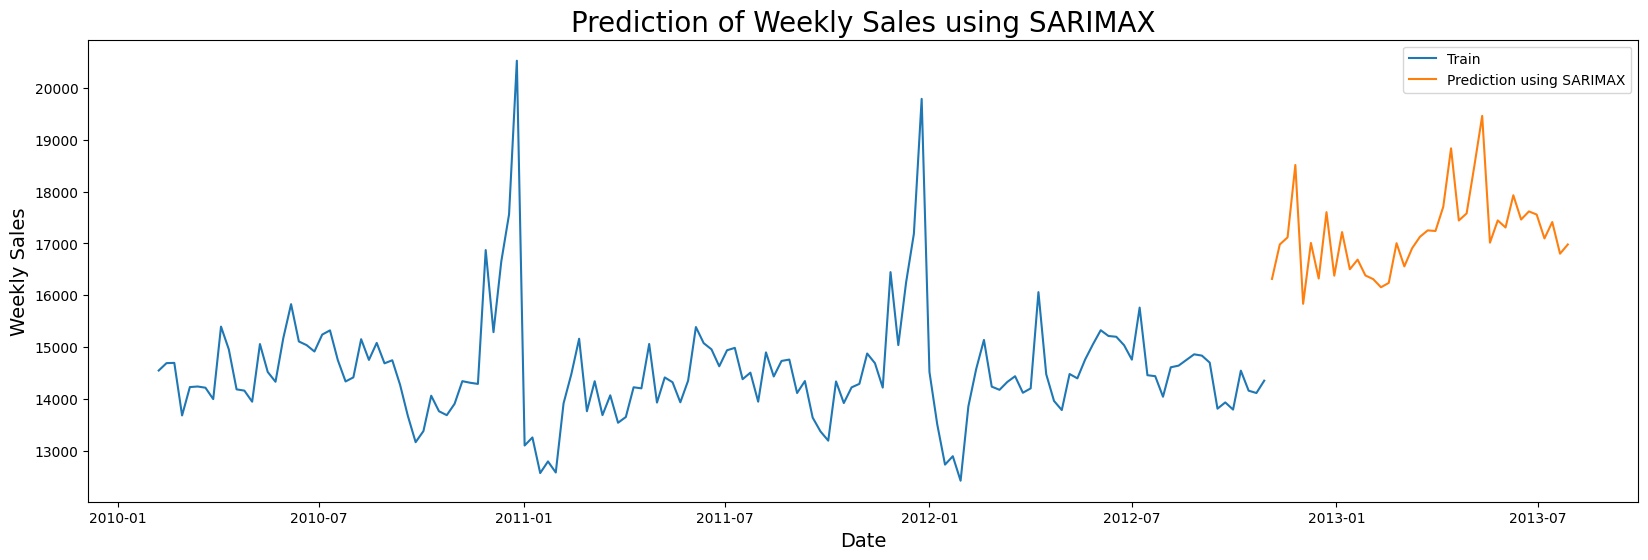

In [313]:
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using SARIMAX', fontsize=20)
plt.plot(data_week['Weekly_Sales'], label='Train')
plt.plot(prediction_test, label='Prediction using SARIMAX')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()












# Conclusion on using the SARIMAX model:

* 1. The model greatly overestimated sales in both the validation sample and the test sample*

* 2. The model did not see seasonality and trends. Has a big mistake. We can conclude that models that take into account seasonality for such data will not suit us*

* 3. To avoid these errors, we will try to use an exponential smoothing model, and also make the data more stationary and use ARIMA and exponential smoothing models on new stationary




.

C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\491221928.py:1: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model_holt_winters = ExponentialSmoothing(train_data_week['Weekly_Sales'], seasonal_periods=18, seasonal='additive',


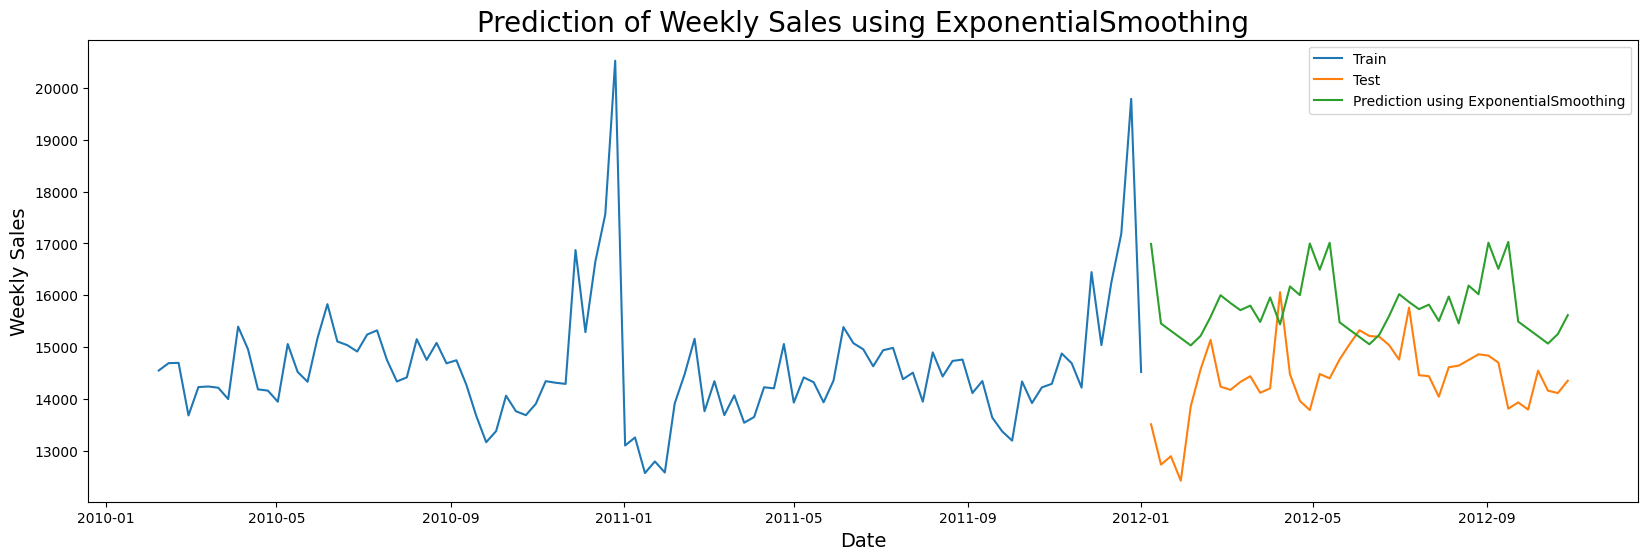

In [314]:
model_holt_winters = ExponentialSmoothing(train_data_week['Weekly_Sales'], seasonal_periods=18, seasonal='additive',
                                           trend='additive',damped=True).fit()
y_pred = model_holt_winters.forecast(len(test_data_week))# Predict the test data


plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_week['Weekly_Sales'], label='Train')
plt.plot(test_data_week['Weekly_Sales'], label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [315]:
print('MAE', metrics.mean_absolute_error(test_data_week['Weekly_Sales'], y_pred))

MAE 1432.412837075689


C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\2525320351.py:1: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model_holt_winters = ExponentialSmoothing(data_week['Weekly_Sales'], seasonal_periods=30, seasonal='additive',
C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


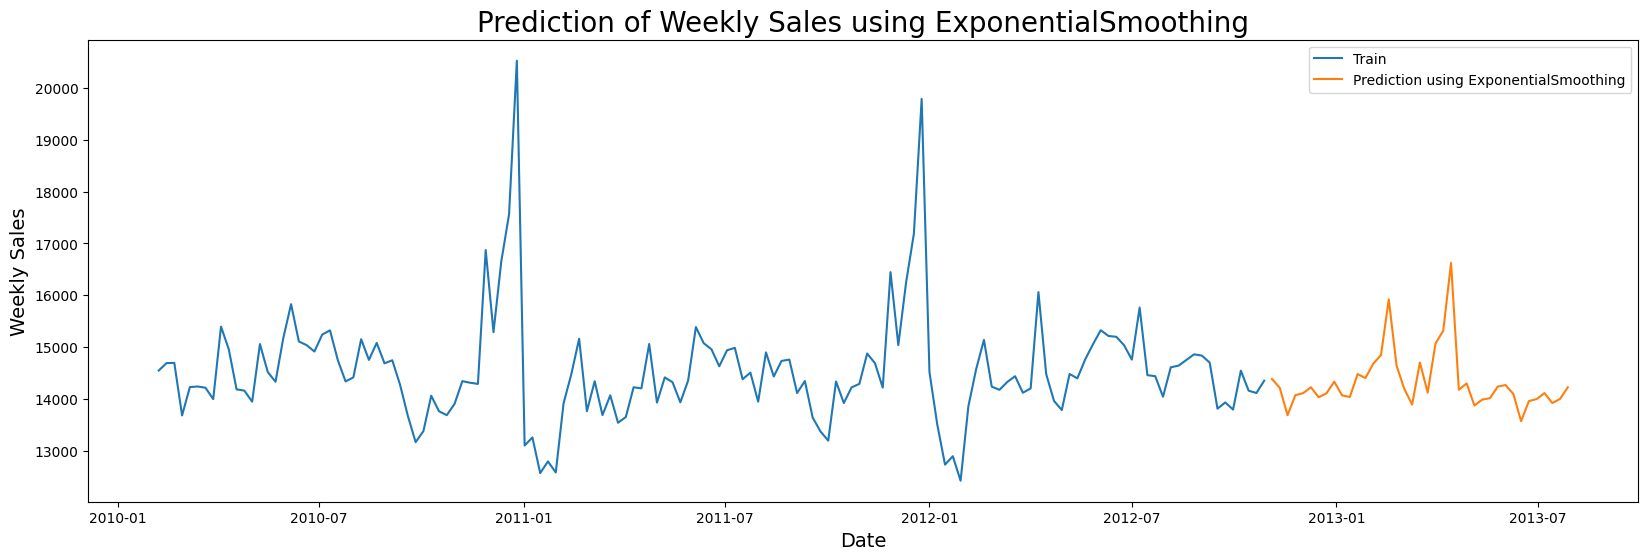

In [316]:
model_holt_winters = ExponentialSmoothing(data_week['Weekly_Sales'], seasonal_periods=30, seasonal='additive',
                                           trend='additive',damped=True).fit() 
y_pred_test = model_holt_winters.forecast(len(test_week))


plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(data_week['Weekly_Sales'], label='Train')
plt.plot(y_pred_test, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


### The exponential smoothing model shows better results, even almost adjusted to the sample, but does not work very well with seasonality.

### On the test dataset we see a good prediction, but the model incorrectly saw seasonality


### *Making the data_date dataset more stationary*

In [317]:
data_date

,Sales
Date,
2010-02-05,14549.305085
2010-02-12,14691.619475
2010-02-19,14696.376289
2010-02-26,13682.561723
2010-03-05,14229.789759
...,...
2012-09-28,13795.449019
2012-10-05,14546.337463
2012-10-12,14159.907752


In [318]:
data_date = data_date['Sales'].diff().dropna()

In [319]:
data_date = data_date.dropna()

In [320]:
data_date = pd.DataFrame(data_date)
data_date

,Sales
Date,
2010-02-12,142.314390
2010-02-19,4.756814
2010-02-26,-1013.814566
2010-03-05,547.228036
2010-03-12,10.966640
...,...
2012-09-28,-138.239109
2012-10-05,750.888443
2012-10-12,-386.429711


In [321]:
result = adfuller(data_date['Sales'])
result 

(-8.349693070179052,
 3.0180679126107465e-13,
 5,
 136,
 {'1%': -3.4793722137854926,
  '5%': -2.8830370378332995,
  '10%': -2.578233635380623},
 2113.934365383546)

In [322]:
train_data_diff = data_date [:int(0.7*(len(data_date )))]
test_data_diff = data_date [int(0.7*(len(data_date ))):]

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1691.174, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1675.260, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1676.271, Time=0.44 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1678.451, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1679.768, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1675.749, Time=0.0

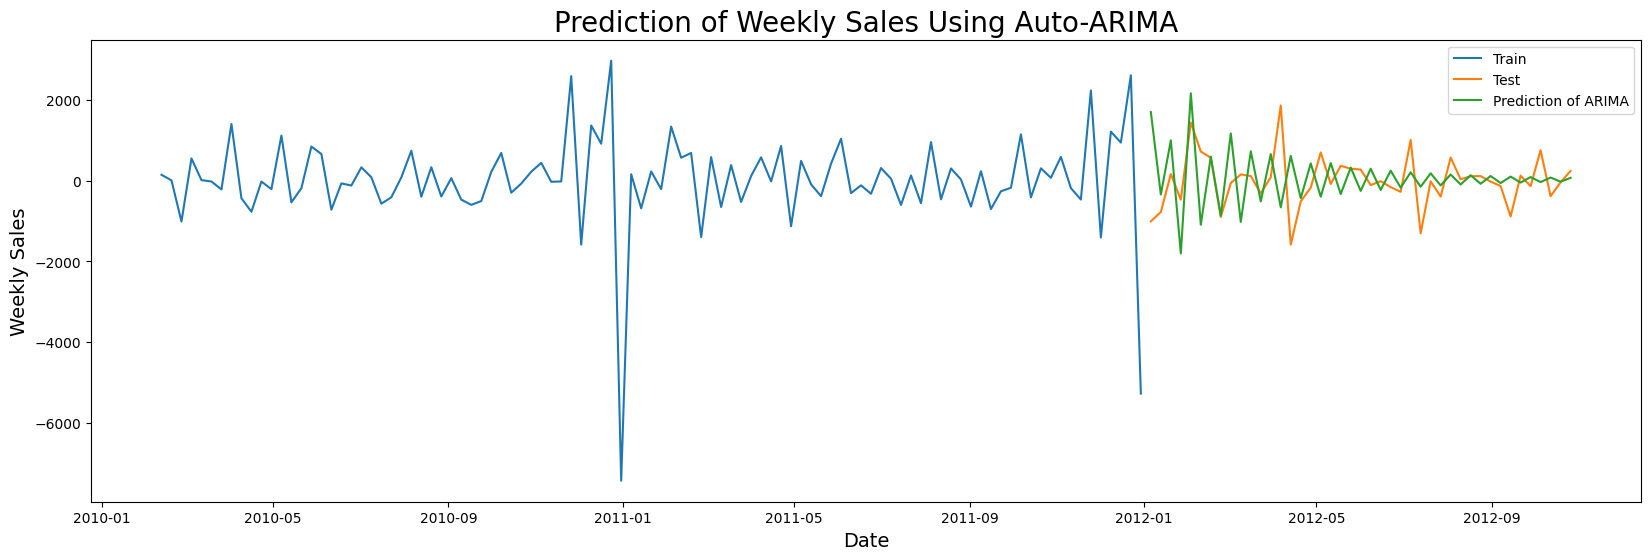

In [323]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=10, max_P=10, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)


y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data_diff.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [324]:
print('MAE', metrics.mean_absolute_error(test_data_diff, y_pred))

MAE 634.3756611129793






## We see a significant reduction in error, but the model does not adapt well to the time series, which can lead to a completely incorrect prediction on the test data set




C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\689436880.py:1: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model_holt_winters = ExponentialSmoothing(train_data_diff['Sales'], seasonal_periods=15, seasonal='additive',
C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


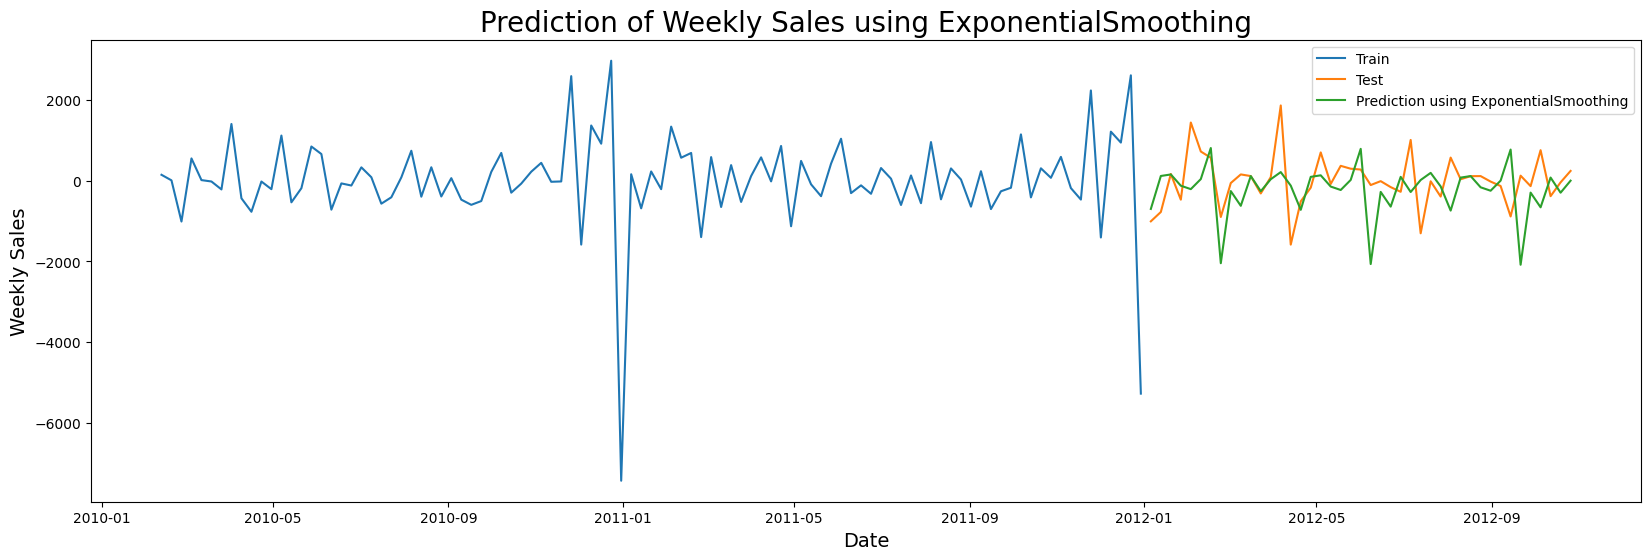

In [325]:
model_holt_winters = ExponentialSmoothing(train_data_diff['Sales'], seasonal_periods=15, seasonal='additive',
                                           trend='additive',damped=True).fit() 
y_pred = model_holt_winters.forecast(len(test_data_diff))


plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff['Sales'], label='Train')
plt.plot(test_data_diff['Sales'], label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [326]:
print('MAE', metrics.mean_absolute_error(test_data_diff, y_pred))

MAE 615.5039634938241


C:\Users\Shant\AppData\Local\Temp\ipykernel_17848\1149357303.py:1: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model_holt_winters = ExponentialSmoothing(data_date['Sales'], seasonal_periods=30, seasonal='additive',
C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Shant\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


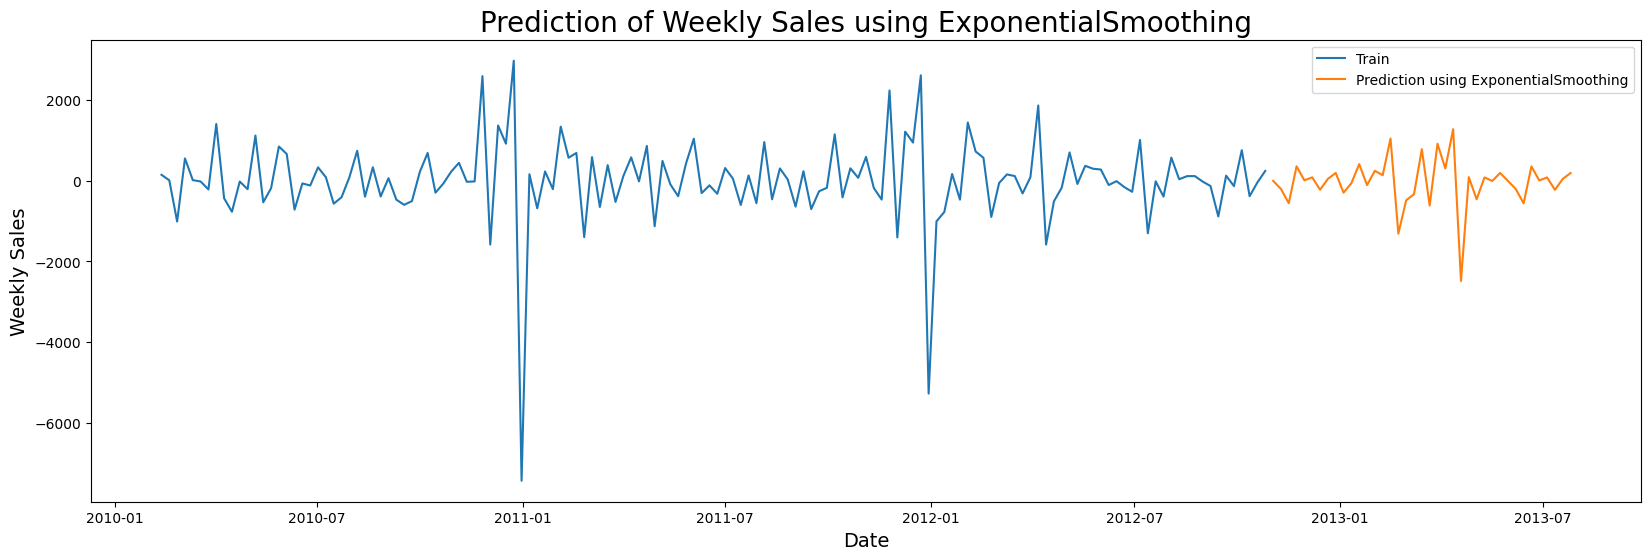

In [327]:
model_holt_winters = ExponentialSmoothing(data_date['Sales'], seasonal_periods=30, seasonal='additive',
                                           trend='additive',damped=True).fit() 
y_pred_test = model_holt_winters.forecast(len(test_week))


plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(data_date['Sales'], label='Train')
plt.plot(y_pred_test, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

### Here the model showed the same small error and good repetition of the time series, as well as a good prediction of the test sample.

### This model will be selected as the best for predicting a given time series using time series analysis models.